In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
import pylab

color_theme = ['#E3170A','#A9E5BB','#FCF6B1','#F7B32B','#2D1E2F', 'green']

params = {'legend.fontsize': 8,#'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 8,#'x-large',
         'axes.titlesize':8,#'x-large',
         'xtick.labelsize':8,#18,
         'ytick.labelsize':8}#18}
          
pylab.rcParams.update(params)
matplotlib.rcParams['font.family'] = ['sans-serif']
matplotlib.rcParams['font.sans-serif']='Arial'

Saitoh and Koshiba Equations to find $\beta$

vec_beta_pred(wln,pitch,d) wln is np.array of wlns to find, pitch airhole centre to centre distance and d is airhole diameter 

In [2]:
def a_values(pitch,d,i):
    if i == 1:
        a_0 = 0.54808
        a_1 = 5.00401
        a_2 = -10.43248
        a_3 = 8.22992
        b_0 = 5
        b_1 = 7
        b_2 = 9
    elif i == 2: 
        a_0 = 0.71041
        a_1 = 9.73481
        a_2 = 47.41496
        a_3 = -437.50962
        b_0 = 1.8
        b_1 = 7.32
        b_2 = 22.8
    elif i == 3:
        a_0 = 0.16904
        a_1 = 1.85765
        a_2 = 18.96849 
        a_3 = -42.4318
        b_0 = 1.7
        b_1 = 10
        b_2 = 14
    elif i == 4:
        a_0 = -1.52736 
        a_1 = 1.06745 
        a_2 = 1.93229 
        a_3 = 3.89
        b_0 = -0.84
        b_1 = 1.02
        b_2 = 13.4
        
    A = a_0 + a_1*(d/pitch)**b_0 + a_2*(d/pitch)**b_1 + a_3*(d/pitch)**b_2
    return A

def b_values(pitch,d,i):
    if i == 1:
        c_0 = -0.0973 
        c_1 = -16.70566 
        c_2 = 67.13845
        c_3 = -50.25518
        d_0 = 7
        d_1 = 9
        d_2 = 10
    elif i == 2: 
        c_0 = 0.53193 
        c_1 = 6.70858
        c_2 = 52.04855 
        c_3 = -540.66947
        d_0 = 1.49
        d_1 = 6.58
        d_2 = 24.8
    elif i == 3:
        c_0 = 0.24876
        c_1 = 2.72423 
        c_2 = 13.28649
        c_3 = -36.80372
        d_0 = 3.85
        d_1 = 10
        d_2 = 15
    elif i == 4:
        c_0 = 5.29801
        c_1 = 0.05142
        c_2 = -5.18302 
        c_3 = 2.7641
        d_0 = -2
        d_1 = 0.41
        d_2 = 6
        
    B = c_0 + c_1*(d/pitch)**d_0 + c_2*(d/pitch)**d_1 + c_3*(d/pitch)**d_2
    return B


def v_value(wln,pitch,d):
    A_1 = a_values(pitch,d,1)
    A_2 = a_values(pitch,d,2)
    A_3 = a_values(pitch,d,3)
    A_4 = a_values(pitch,d,4)
    
    V = A_1 + A_2/(1+A_3*np.exp(A_4*wln/pitch))
    return V


def w_value(wln,pitch,d):
    B_1 = b_values(pitch,d,1)
    B_2 = b_values(pitch,d,2)
    B_3 = b_values(pitch,d,3)
    B_4 = b_values(pitch,d,4)
    
    W = B_1 + B_2/(1+B_3*np.exp(B_4*wln/pitch))
    return W

def find_n_clad(wln):
    n_clad = np.sqrt(1 + (0.6961663*wln**2)/(wln**2 - 0.004679148) +
                 (0.4079426*wln**2)/(wln**2 - 0.01351206) +
                 (0.8974794*wln**2)/(wln**2 - 97.93400)) # Cladding index
    return n_clad


def beta_prediction(wln,pitch,d):
    V = v_value(wln,pitch,d)
    W = w_value(wln,pitch,d)
    U_squared = (V**2 - W**2)
    nclad = find_n_clad(wln*1e6)
    # print(nclad)
    n_eff_sqaured = nclad**2 - 3*U_squared*wln**2/(4*np.pi**2 * 25*pitch**2)
    n_eff = np.sqrt(n_eff_sqaured)
    return n_eff*np.pi*2/wln

vec_beta_pred = np.vectorize(beta_prediction)

In [3]:
def get_random_colours(n, threshold):

    random_cols = np.random.rand(n,3)
    dist_matrix = cdist(random_cols, random_cols, 'euclidean') 

    while np.any(dist_matrix+np.eye(n) < threshold):
        # print('here')
        # if any values in the distance matrix are
        # less than the threshold all colors are re-rolled
        # n sets of RGB coords
        random_cols = np.random.rand(n,3)
        # Calculate distance in color space
        dist_matrix = cdist(random_cols, random_cols, 'euclidean') 

    return random_cols

colors = get_random_colours(4,0.1)
print(colors)

[[0.63733511 0.70131068 0.23663135]
 [0.87285222 0.06766797 0.74502521]
 [0.84600669 0.29286292 0.17529472]
 [0.35118761 0.8553285  0.67901321]]


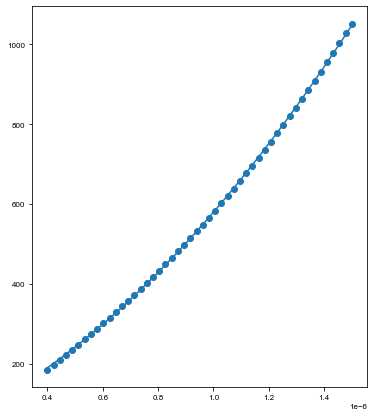

In [4]:
coupling_data = pd.read_csv('../COMSOL/Data/Spiral/spiral coupling wavelength data.csv', skiprows=4)
coupling_data.rename(columns={'% lda0 (um)': 'Wavelength', 'Propagation constant (rad/m)': 'PropagationConstant'}, inplace = True)
coupling_pol_1 = coupling_data[::2]
prop_consts_list = coupling_pol_1.PropagationConstant.to_numpy()
wavelengths = coupling_data.Wavelength[::4].to_numpy()*1e-6
prop_diff = np.abs((prop_consts_list[::2] - prop_consts_list[1::2])/2)
# plt.plot(coupling_data.Wavelength[::4].to_numpy*1e-6, prop_diff)
z = np.polyfit(wavelengths, prop_diff,2)
p = np.poly1d(z)
x_vals = np.linspace(0.4,1.5,1000)*1e-6
fig_coupling = plt.figure(figsize=(6,7))
ax_coupling = fig_coupling.add_subplot(111)
ax_coupling.scatter(wavelengths, prop_diff)
ax_coupling.plot(x_vals, p(x_vals))
plt.show()
# print(z)

0.5011073097241647


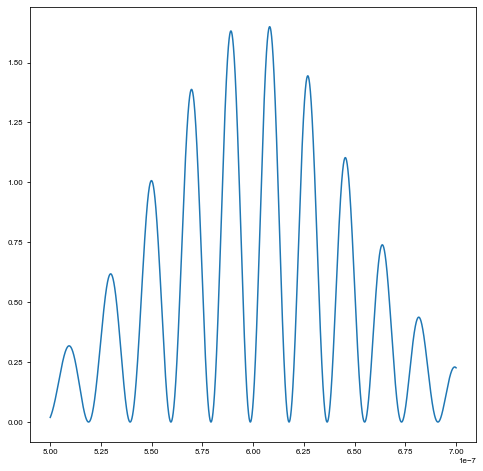

In [23]:
# Test for sin^2 variation over cm scale 
lambda_test_range = np.linspace(0.5,0.7,10000)*1e-6
c1_list = p(lambda_test_range)
c2_list = c1_list*0.55
mod_zeta_min = np.sqrt(c1_list**2 + c2_list**2)
z = 0.24
sin_var = np.sin(mod_zeta_min*z)**2
test_weighting = std_weighting_func_norm(lambda_test_range, 50e-9)
plt.plot(lambda_test_range,sin_var*test_weighting)
# plt.axhline(np.mean(sin_var))
print(np.mean(sin_var*test_weighting))

In [5]:
def SSH_eigvecs(w,v,betas):
    onsite = np.diag(betas)
    h = np.array([[0,w,0,0,0,0,0,0,0,0,0,0],
                [w,0,v,0,0,0,0,0,0,0,0,0],
                [0,v,0,w,0,0,0,0,0,0,0,0],
                [0,0,w,0,v,0,0,0,0,0,0,0],
                [0,0,0,v,0,w,0,0,0,0,0,0],
                [0,0,0,0,w,0,v,0,0,0,0,0],
                [0,0,0,0,0,v,0,w,0,0,0,0],
                [0,0,0,0,0,0,w,0,v,0,0,0],
                [0,0,0,0,0,0,0,v,0,w,0,0],
                [0,0,0,0,0,0,0,0,w,0,v,0],
                [0,0,0,0,0,0,0,0,0,v,0,w],
                [0,0,0,0,0,0,0,0,0,0,w,0]])    
    eigvals,eigvecs = np.linalg.eigh(h+onsite)
    
    return eigvals,eigvecs


def SSH_eigvecs_rand(w,v,betas,onsite_terms):
    onsite = np.diag(betas)
    random_disorder = np.diag(onsite_terms)
    h = np.array([[0,w,0,0,0,0,0,0,0,0,0,0],
                [w,0,v,0,0,0,0,0,0,0,0,0],
                [0,v,0,w,0,0,0,0,0,0,0,0],
                [0,0,w,0,v,0,0,0,0,0,0,0],
                [0,0,0,v,0,w,0,0,0,0,0,0],
                [0,0,0,0,w,0,v,0,0,0,0,0],
                [0,0,0,0,0,v,0,w,0,0,0,0],
                [0,0,0,0,0,0,w,0,v,0,0,0],
                [0,0,0,0,0,0,0,v,0,w,0,0],
                [0,0,0,0,0,0,0,0,w,0,v,0],
                [0,0,0,0,0,0,0,0,0,v,0,w],
                [0,0,0,0,0,0,0,0,0,0,w,0]])    
    eigvals,eigvecs = np.linalg.eigh(h+random_disorder+onsite)
    return eigvals,eigvecs

In [6]:
# function to take input vector, 
# overlap with eigvals to describe as supermodes,
# then propagate using z dependence

def super_mode(z,evals,evecs,input_vec):
    psi_list = np.zeros([len(evals),len(evals)],dtype=complex)
    # overlap input vec with all eigenvecs to build supermode
    for i,val in enumerate(evals):
        # print(val)
        ind_vec = evecs[:,i]
        # print(i)
        # print(np.vdot(ind_vec,input_vec)*ind_vec*np.exp(1.0j*val*z))
        psi_list[:,i] = np.vdot(ind_vec,input_vec)*ind_vec*np.exp(1.0j*val*z)
    # sum up supermode contributions after propagation
    psi = np.sum(psi_list,axis=1)
    # print(psi*np.conjugate(psi))
    return psi

# Function to compute overlap to return to core basis for plotting
def core_basis(prop_wave, number_of_cores):
    
    core_matrix = np.eye(number_of_cores) 
    a_list = np.zeros(number_of_cores, dtype=complex)
    
    for i in range(number_of_cores):
        a_list[i] = np.vdot(core_matrix[:,i],prop_wave)
        
    # We find the contribution from each core through these overlaps
    return a_list

# Function to find weigthed intensity difference at a given distance
def I_d_bar_at_z(z,evals,evecs,input_vec):
    # find supermodes
    supe = super_mode(z,evals,evecs,input_vec)
    # a_vals = core_basis(supe,12)
    # Intensity in each core
    # norm_vals = a_vals*np.conj(a_vals)
    
    norm_vals = supe*np.conj(supe)
#     print(norm_vals)
    norm_vals = norm_vals/np.sum(norm_vals)
    # print(norm_vals)
    # split cores into a & b
    a_norm = norm_vals[::2]
    b_norm = norm_vals[1::2]
    # find unweighted difference
    diff_list = a_norm - b_norm
    # weight the difference
    scaled_diff_list = diff_list*np.arange(1,7)
    # Calculate final values for use
    I_d = np.sum(scaled_diff_list)
    unweighted_diff = np.sum(diff_list)
    
    
    return I_d,unweighted_diff#,norm_vals

In [7]:
def Id_for_different_wavelengths(z, each_wvln, input_vec, rand_mag=0.0, trivial=False):#eigenvalue_list_at_each_wvln, eigenvectors, input_vec):

    Id_wvln_list = np.zeros(len(each_wvln), dtype=complex)
    unweighted_id_wvln_list = np.zeros(len(each_wvln), dtype=complex)
    prop_consts_at_each_wvln = vec_beta_pred(each_wvln, 4.35, 1.63)
    rand_list = (np.random.rand(12)-0.5)
    
    for i, beta_at_wvln in enumerate(prop_consts_at_each_wvln):
        
        prop_consts_i = np.ones(12)*beta_at_wvln
        if trivial is True:
            weak_coupling = p(each_wvln[i])
            strong_coupling = p(each_wvln[i])*0.45
        else:
            strong_coupling = p(each_wvln[i])
            weak_coupling = p(each_wvln[i])*0.45
        eigenvalues, eigenvectors = SSH_eigvecs_rand(weak_coupling, strong_coupling, prop_consts_i, rand_list*rand_mag*strong_coupling)
        # print(eigenvectors[:,0])
        Id_wvln_list[i], unweighted_id_wvln_list[i] = I_d_bar_at_z(z, eigenvalues, eigenvectors, input_vec)
    
    return Id_wvln_list,unweighted_id_wvln_list




In [8]:
def Id_for_different_wavelengths_coupling(z, each_wvln, input_vec, coupling_multiplier, trivial=False):#eigenvalue_list_at_each_wvln, eigenvectors, input_vec):

    Id_wvln_list = np.zeros(len(each_wvln), dtype=complex)
    unweighted_id_wvln_list = np.zeros(len(each_wvln), dtype=complex)
    prop_consts_at_each_wvln = vec_beta_pred(each_wvln, 4.35, 1.63)
    rand_list = (np.random.rand(12)-0.5)
    
    for i, beta_at_wvln in enumerate(prop_consts_at_each_wvln):
        
        prop_consts_i = np.ones(12)*beta_at_wvln
        if trivial is True:
            weak_coupling = p(each_wvln[i])*coupling_multiplier
            strong_coupling = p(each_wvln[i])*0.45*coupling_multiplier
        else:
            strong_coupling = p(each_wvln[i])*coupling_multiplier
            weak_coupling = p(each_wvln[i])*0.45*coupling_multiplier
        eigenvalues, eigenvectors = SSH_eigvecs(weak_coupling, strong_coupling, prop_consts_i)
        # print(eigenvectors[:,0])
        Id_wvln_list[i], unweighted_id_wvln_list[i] = I_d_bar_at_z(z, eigenvalues, eigenvectors, input_vec)
    
    return Id_wvln_list

## ID over different wavelength ranges

In [9]:
wvln_list_list = []
Id_data_list_list = []
unweighted_list_list = []
input_core = np.zeros(12, dtype=complex)
input_core[6] = 1.0
number_of_wavelength_ranges = 15
wvln_start_list = np.linspace(0.575,0.63,number_of_wavelength_ranges)
for n in wvln_start_list:
    wvln_list = np.linspace(n,n+0.08, 1000)*1e-6 ## must be in microns
    beta_list = vec_beta_pred(wvln_list, 4.35, 1.63)
# vals, vecs = SSH_eigvecs(166, 360)
# beta_list = beta_list[0] - beta_list
# vals_with_beta = np.broadcast_to(vals, (100,12)) + np.transpose(np.broadcast_to(beta_list, (12,100)))
    wvln_list_list.append(wvln_list)

# ID_at_dist = []
# for i in range(100):
    Id_data, unweight_data = Id_for_different_wavelengths(0.23, wvln_list, input_core, rand_mag=0.15, trivial=False)#vals_with_beta, vecs, input_core)
    Id_data_list_list.append(Id_data)
    unweighted_list_list.append(unweight_data)
    # Iprint(2*np.mean(Id_data))

c:\Users\nr421\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


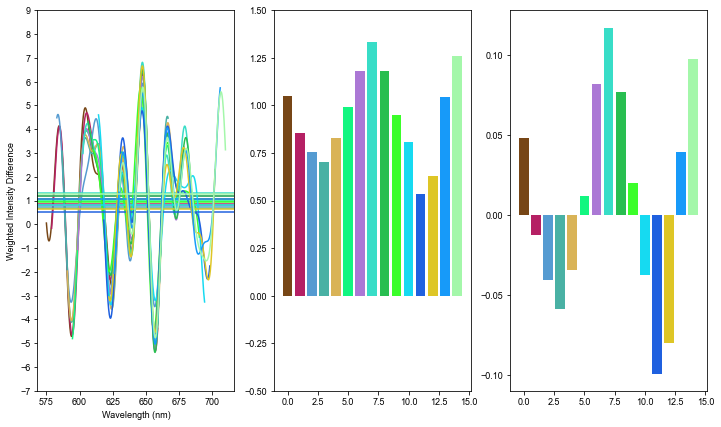

In [10]:
fig_id = plt.figure(figsize=(12,7))
ax_id = fig_id.add_subplot(131)
ax_id_bar = fig_id.add_subplot(132)
ax_id_unweight = fig_id.add_subplot(133)
col_list = get_random_colours(number_of_wavelength_ranges,0.2)
for k in range(len(wvln_list_list)):
    ax_id.plot(1e9*wvln_list_list[k], 2*Id_data_list_list[k], color = col_list[k])
    ax_id.axhline(2*np.mean(Id_data_list_list[k]), color = col_list[k])
# print(np.mean(Id_data_list_list,axis=1))
ax_id_bar.bar(np.arange(number_of_wavelength_ranges), 2*np.mean(Id_data_list_list,axis=1), color=col_list)
ax_id_unweight.bar(np.arange(number_of_wavelength_ranges), 2*np.mean(unweighted_list_list,axis=1), color=col_list)
ax_id_bar.set_ylim(-.5, 1.5)
# ax_id.set_ylim(-0.5, 2)
ax_id.set_yticks(np.arange(-7,10,1))
ax_id.set_xlabel('Wavelength (nm)')
ax_id.set_ylabel('Weighted Intensity Difference')
# ax_id.axhline(2*np.mean(Id_data_1), color='blue')
# ax_id.axhline(2*np.mean(Id_data_2), color='green')
# ax_id.axhline(2*np.mean(Id_data_3), color='purple')
# ax_id.axhline(2*np.mean(Id_data_4), color='red')

plt.show()
# fig_id.savefig('Intensity diff over small lambda range.png', dpi=300)

# print(np.transpose(np.broadcast_to(beta_list, (12,100)))[0])

## ID over one range (680-760) with different levels of random disorder

In [11]:
wvln_list_rand = np.linspace(0.58,0.65, 1000)*1e-6 ## must be in microns
Id_data_list_rand = []
unweight_list_rand = []
input_core = np.zeros(12, dtype=complex)
input_core[6] = 1.0
input_core[0] = 0.0
fibre_realisations = 15
dis_mag_list =  np.linspace(0.00,0.3, fibre_realisations)

for n in dis_mag_list:
    Id_data,unweight_rand_data = Id_for_different_wavelengths(0.25, wvln_list_rand, input_core, rand_mag=n)
    Id_data_list_rand.append(Id_data)
    unweight_list_rand.append(unweight_rand_data)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


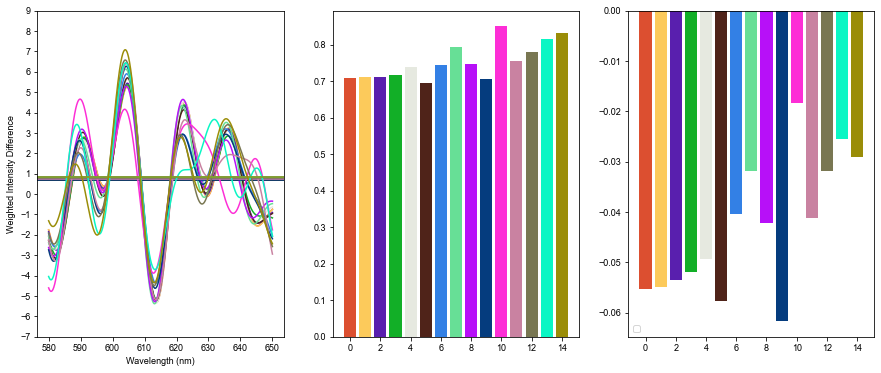

In [12]:
fig_id_rand = plt.figure(figsize=(15,6))
ax_id_rand = fig_id_rand.add_subplot(131)
ax_bar_rand = fig_id_rand.add_subplot(132)
ax_unweight_rand = fig_id_rand.add_subplot(133)

col_list = get_random_colours(fibre_realisations,0.3) 


for n,k in enumerate(dis_mag_list):
    ax_id_rand.plot(1e9*wvln_list_rand, 2*Id_data_list_rand[n], color = col_list[n], label='Disorder/Strong Coupling: {}'.format(np.round(k,2)))
    ax_id_rand.axhline(2*np.mean(Id_data_list_rand[n]), color = col_list[n])


ax_bar_rand.bar(np.arange(fibre_realisations), 2*np.mean(Id_data_list_rand,axis=1), color=col_list)
ax_unweight_rand.bar(np.arange(fibre_realisations), 2*np.mean(unweight_list_rand,axis=1), color=col_list)
# ax_id_rand.set_ylim(-0.5, 2)
ax_id_rand.set_yticks(np.arange(-7,10,1))
ax_id_rand.set_xlabel('Wavelength (nm)')
ax_id_rand.set_ylabel('Weighted Intensity Difference')
# ax_id.axhline(2*np.mean(Id_data_1), color='blue')
# ax_id.axhline(2*np.mean(Id_data_2), color='green')
# ax_id.axhline(2*np.mean(Id_data_3), color='purple')
# ax_id.axhline(2*np.mean(Id_data_4), color='red')
plt.legend()
plt.show()

# fig_id_rand.savefig('Intensity diff with random onsite.png', dpi=300)

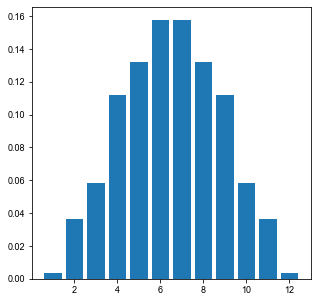

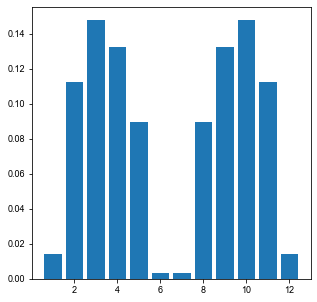

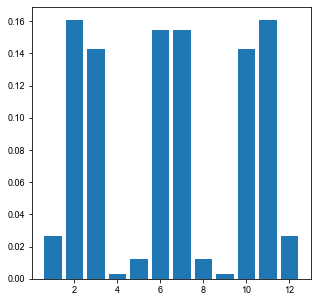

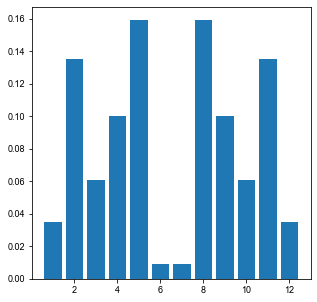

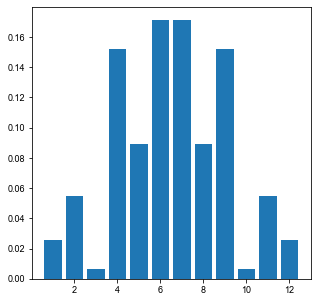

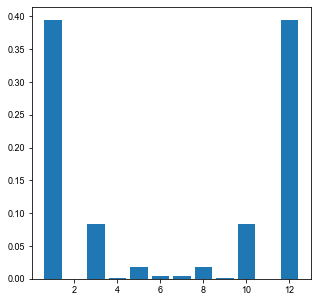

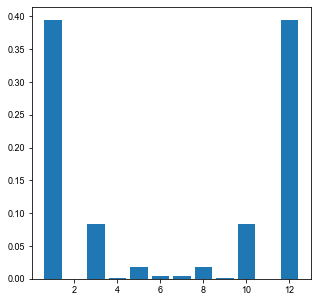

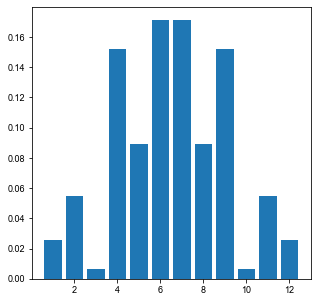

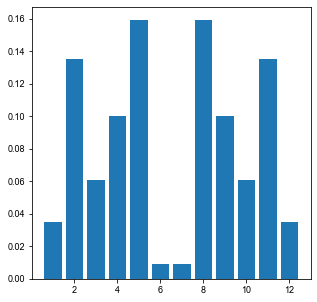

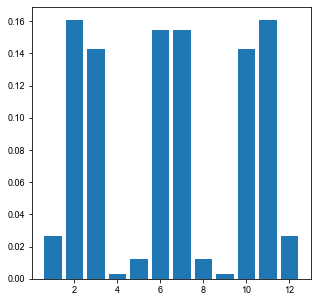

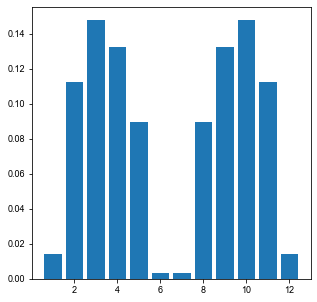

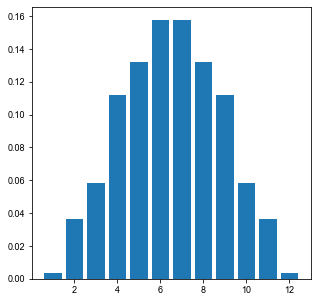

482.5663707796484


In [13]:
vals, vecs = SSH_eigvecs(166, 361, np.ones(12)*beta_list[0])
for i in range(12):
    fig_bar = plt.figure(figsize=(5,5))
    ax_bar = fig_bar.add_subplot(111)
    ints = np.conjugate(vecs)*vecs
    ax_bar.bar(np.arange(1,13), ints[:,i]/np.sum(ints[:,i]))
    plt.show() 

print(vals[7]-vals[4])

## Making sloped intensity spectra

In [14]:
def weighting_func_slant(lambdas):
    mean = np.mean(lambdas)
    std = np.std(lambdas)
    y_out_slant = 1/(std*np.sqrt(2*np.pi)) * np.exp(- (lambdas - mean)**2 / (2*std**2))# + np.power(1e4*np.arange(len(lambdas)),1)[::-1]
    # print(y_out_slant)
    weight_ratio = np.sum(y_out_slant)/len(lambdas)
    return y_out_slant/weight_ratio

In [15]:
def variable_weighting_func_slant(lambdas,n):
    mean = np.mean(lambdas)
    std = np.std(lambdas)
    y_out_slant = 1/(std*np.sqrt(2*np.pi)) * np.exp(- (lambdas - mean)**2 / (2*std**2)) + n#+ np.power(1e4*np.arange(len(lambdas)),n)[::-1]
    # print(y_out_slant)
    weight_ratio = np.sum(y_out_slant)/len(lambdas)
    return y_out_slant/weight_ratio

In [16]:
wvln_list_slant = np.linspace(0.60,0.70, 1000)*1e-6 ## must be in microns
wvln_list_reduced = np.linspace(0.710,0.790, 1000)*1e-6
Id_data_list_uniform = []
input_core = np.zeros(12, dtype=complex)
input_core[5] = 1.0
Id_data_uniform, unweighted_id_uniform = Id_for_different_wavelengths(0.237, wvln_list_slant, input_core, rand_mag=0.0)
Id_data_uniform_reduced, unweighted_id_uniform_reduced  = Id_for_different_wavelengths(0.25, wvln_list_reduced, input_core, rand_mag=0.0)
# Id_data_list_uniform.append(Id_data_uniform)

print(np.mean(Id_data_uniform))

(0.48732350529525187+0j)


In [16]:
print(np.shape(Id_data_uniform))

(1000,)


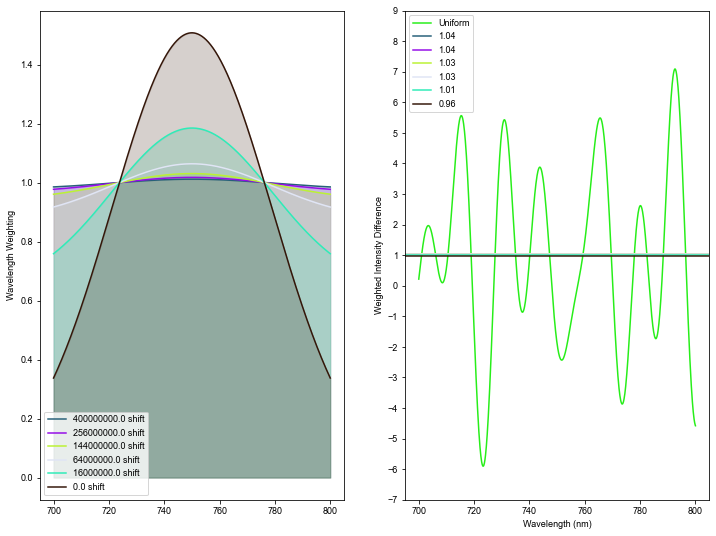

In [20]:
slant_weighting = weighting_func_slant(wvln_list_slant)
step_list = [-1 if x < 710e-9 or x > 780e-9 else +1 for x in wvln_list_slant]
top_hat = np.heaviside(step_list,1)

Id_data_list_slant = np.multiply(Id_data_uniform,slant_weighting)
Id_data_list_slant = np.reshape(Id_data_list_slant, 1000)

fig_id_slant = plt.figure(figsize=(12,9))
ax_id_slant = fig_id_slant.add_subplot(122)
ax_id_step = fig_id_slant.add_subplot(121)
# ax_id_step = ax_id_slant.twinx()

col_list = get_random_colours(8,0.5) 

# ax_id_slant.plot(1e9*wvln_list_slant, 2*Id_data_list_slant, color = col_list[0])
# ax_id_slant.axhline(2*np.mean(Id_data_list_slant), color = col_list[0])
ax_id_slant.plot(1e9*wvln_list_slant, 2*Id_data_uniform, color = col_list[1],label='Uniform')
ax_id_slant.axhline(2*np.mean(Id_data_uniform),ls='--', color = col_list[1])
# ax_id_step.plot(1e9*wvln_list_slant,top_hat, color= col_list[2])
# ax_id_slant.axhline(2*np.mean(Id_data_uniform_reduced), color=col_list[2])
# ax_id_rand.set_ylim(-0.5, 2)

for i,n in enumerate(np.power(np.linspace(0,20000,6),2)[::-1]):
    slant_weighting = variable_weighting_func_slant(wvln_list_slant,n)
    Id_data_list_slant = np.multiply(Id_data_uniform,slant_weighting)
    ax_id_step.plot(wvln_list_slant*1e9, slant_weighting,color=col_list[i+2],label='{} shift'.format(np.round(n,2)))
    ax_id_slant.axhline(2*np.mean(Id_data_list_slant), color = col_list[i+2],label='{}'.format(np.round(np.real(2*np.mean(Id_data_list_slant)),2)))
    ax_id_step.fill_between(1e9*wvln_list_slant,slant_weighting,color=col_list[i+2],alpha=0.2)
ax_id_slant.legend()
ax_id_step.legend()

# ax_id_step.set_ylim(0.0, 1.1)
ax_id_slant.set_yticks(np.arange(-7,10,1))
ax_id_slant.set_xlabel('Wavelength (nm)')
ax_id_slant.set_ylabel('Weighted Intensity Difference')
ax_id_step.set_ylabel('Wavelength Weighting')
# ax_id.axhline(2*np.mean(Id_data_1), color='blue')
# ax_id.axhline(2*np.mean(Id_data_2), color='green')
# ax_id.axhline(2*np.mean(Id_data_3), color='purple')
# ax_id.axhline(2*np.mean(Id_data_4), color='red')

plt.show()
# fig_id_slant.savefig('Id and relative intensity for chosing range.svg', dpi=300)

In [17]:
def std_weighting_func_norm(lambdas,std):
    mean = np.mean(lambdas)
    # std = np.std(lambdas)
    y_out_slant = 1/(std*np.sqrt(2*np.pi)) * np.exp(- (lambdas - mean)**2 / (2*std**2)) #+ n#+ np.power(1e4*np.arange(len(lambdas)),n)[::-1]
    # print(y_out_slant)
    weight_ratio = np.sum(y_out_slant)/len(lambdas)
    return y_out_slant/weight_ratio

def std_weighting_func_lorentzian(lambdas,hwhm):
    mean = np.mean(lambdas)
    # std = np.std(lambdas)
    y_out_slant = (1/np.pi) * (hwhm/((lambdas-mean)**2 +hwhm**2)) #+ n#+ np.power(1e4*np.arange(len(lambdas)),n)[::-1]
    # print(y_out_slant)
    weight_ratio = np.sum(y_out_slant)/len(lambdas)
    return y_out_slant/weight_ratio

In [18]:
def rms_width(datax, datay):

    norm = datay / np.sum(datay)
    meanx = np.sum(np.multiply(datax, norm))
    xzero = datax - meanx
    width = np.sqrt(np.sum(np.multiply(xzero**2, norm)))

    return width

5.779279084228417


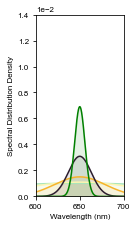

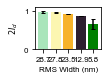

[28.7, 27.8, 23.5, 12.9, 5.8]


In [32]:
cm = 1/2.54
fig_weights = plt.figure(figsize=(4.0*cm,8.5*cm))
fig_flat = plt.figure(figsize=(3.0*cm,2.0*cm))
ax_weights = fig_weights.add_subplot(111)
ax_flat = fig_flat.add_subplot(111)
# ax_id_v_norm = fig_weights.add_subplot(133)


y_uniform = np.ones(len(wvln_list_slant))#*1/len(wvlns)
std = np.std(wvln_list_slant)
# ax_weights.plot(wvln_list_slant*1e9, y_uniform)

col_list = color_theme# get_random_colours(11,0.35) 

# ax_flat.plot(1e9*wvln_list_slant, 2*Id_data_uniform, color = col_list[0],label='Uniform')
# ax_flat.bar(0, 2*np.mean(Id_data_uniform), color = col_list[0],label='{}'.format(np.round(np.real(2*np.mean(Id_data_uniform)),2)))
# ax_weights.axhline(1.0,xmin=0.0,xmax=1.0,color=col_list[0])
# ax_weights.fill_between(1e9*wvln_list_slant,1.0,color=col_list[0],alpha=0.1)
id_for_diff_std = []
rms_width_list = np.zeros(5)
# rms_width_list[0] = rms_width(wvln_list_slant, np.ones(len(wvln_list_slant)))
print(std*1e9/5)
for n,i in enumerate(np.geomspace(std*5,std/5,5)):
    y_norm_slant = std_weighting_func_norm(wvln_list_slant,i)
    norm_y_norm_slant_to_plot = y_norm_slant/np.sum(y_norm_slant)
    rms_width_list[n] =  rms_width(wvln_list_slant, y_norm_slant)
    Id_data_list_norm = np.multiply(Id_data_uniform,y_norm_slant)
    unweighted_data_list = np.multiply(unweighted_id_uniform, y_norm_slant)
    ax_weights.plot(wvln_list_slant*1e9, norm_y_norm_slant_to_plot, color=col_list[n+1])
    ax_weights.fill_between(1e9*wvln_list_slant,norm_y_norm_slant_to_plot,color=col_list[n+1],alpha=0.1)
    
    ax_flat.bar(n, 2*np.mean(Id_data_list_norm),yerr=3*np.mean(unweighted_data_list), color = col_list[n+1],label='{}'.format(np.round(np.real(2*np.mean(Id_data_list_norm)),2)), capsize=2)
    id_for_diff_std.append(2*np.mean(Id_data_list_norm))

# ax_id_v_norm.scatter(1/np.geomspace(std*50,std/2,10),id_for_diff_std, color=col_list[1:])
# ax_id_v_norm.set_ylim(0,1.1)
# ax_flat.legend()
rms_list_str = [np.round(x*1e9,1) for x in rms_width_list]
ax_weights.set_ylim(0,0.014)
ax_flat.set_ylim(0.0,1.1)
ax_weights.set_ylabel('Spectral Distribution Density')
ax_weights.set_xlabel('Wavelength (nm)')
ax_flat.set_ylabel('$2I_{d}$')
ax_flat.set_xticks(np.arange(5))
ax_flat.set_xticklabels(rms_list_str)
# ax_flat.set_xlabel('Wavelength (nm)')
ax_weights.set_xlim(600,700)
# ax_flat.set_xticklabels([710,790])
# ax_id_v_norm.set_ylabel('$2I_{d}$')
ax_flat.set_xlabel('RMS Width (nm)')
ax_weights.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax_id_v_norm.set_xlabel(r'1/(Standard Deviation of Distribution)')
fig_weights.savefig('different distributions analytic small.svg', dpi=300)
fig_flat.savefig('id for different distributions small.svg', dpi=300)
plt.show()

print(rms_list_str)

In [41]:
print(type(rms_width_list[0]))

<class 'numpy.float64'>


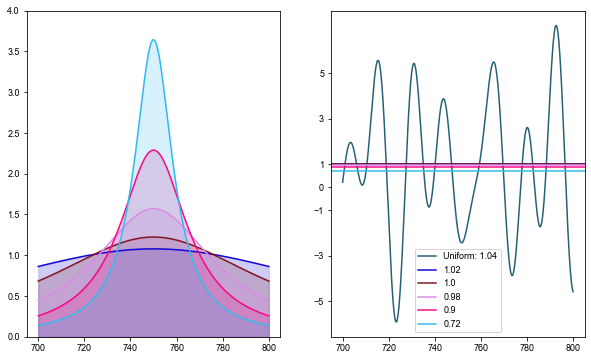

In [21]:
fig_loz = plt.figure(figsize=(10,6))
ax_loz= fig_loz.add_subplot(121)

ax_loz_flat = fig_loz.add_subplot(122)
# print(wvln_list_slant)

col_list = get_random_colours(6,0.5) 
ax_loz_flat.plot(1e9*wvln_list_slant, 2*Id_data_uniform, color = col_list[0],label='Uniform: {}'.format(2*np.round(np.real(np.mean(Id_data_uniform)),2)))
ax_loz_flat.axhline(2*np.mean(Id_data_uniform),ls='--', color = col_list[0])
y_uniform = np.ones(len(wvln_list_slant))#*1/len(wvlns)
std = np.std(wvln_list_slant)
# ax_weights.plot(wvln_list_slant*1e9, y_uniform)
for n,i in enumerate(np.geomspace(100e-9,10e-9,5)):
    y_loz_slant = std_weighting_func_lorentzian(wvln_list_slant,i)
    Id_data_list_loz = np.multiply(Id_data_uniform, y_loz_slant)
    ax_loz.fill_between(1e9*wvln_list_slant,y_loz_slant,color=col_list[n+1],alpha=0.2)
    ax_loz_flat.axhline(2*np.mean(Id_data_list_loz), color = col_list[n+1], label='{}'.format(2*np.round(np.real(np.mean(Id_data_list_loz)),2)))
    ax_loz.plot(wvln_list_slant*1e9, y_loz_slant, color= col_list[n+1])
ax_loz_flat.legend()
ax_loz_flat.set_yticks([-5,-3,-1,0,1,3,5])
ax_loz.set_ylim(0,4)
plt.show()

## Plotting distance dependent I_{d} and Wavelength dependent 

In [20]:
id_at_dist = []
z_points = np.linspace(0.23,0.28,1000)
unweighted_at_dist = []

for z in z_points:
    id_val, un_val = Id_for_different_wavelengths(z,[0.65e-6], input_core, 0.0)
    id_at_dist.append(id_val)
    unweighted_at_dist.append(un_val)


id_at_dist = np.reshape(id_at_dist, 1000)

c:\Users\nr421\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Users\nr421\Anaconda3\lib\site-packages\numpy\ma\core.py:3337: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


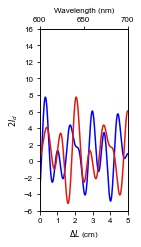

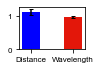

In [34]:
fig_id_z = plt.figure(figsize=(4.0*cm,8.5*cm))
fig_mean_zoom = plt.figure(figsize=(3.0*cm, 2.0*cm))
ax_id_z = fig_id_z.add_subplot(111)
ax_mean_zoom = fig_mean_zoom.add_subplot(111)
ax_id_lambda = ax_id_z.twiny()

col_list = color_theme[:2]#get_random_colours(2,0.5) 

ax_id_z.plot((z_points-z_points[0])*100, 2*id_at_dist, color = 'blue')#col_list[1])
ax_mean_zoom.bar(0,  2*np.mean(id_at_dist), yerr=3*np.mean(unweighted_at_dist), color = 'blue', width=0.30, capsize=2)# col_list[1])


ax_id_lambda.plot(1e9*wvln_list_slant, 2*Id_data_uniform, color = col_list[0])
ax_mean_zoom.bar(0.7, 2*np.mean(Id_data_uniform), yerr=3*np.mean(unweighted_id_uniform), color = col_list[0], width= 0.30, capsize=2)

# ax_mean_zoom.set_ylim(0.0, 1.2)
ax_id_z.set_xlim(0,5)
ax_id_z.set_xticks(np.arange(0,6))
ax_id_lambda.set_xlim(600,700)
ax_id_z.set_yticks(np.arange(-6,18,2))
ax_id_z.set_xlabel('$\Delta L$ (cm)')
ax_id_z.set_ylabel('$2I_{d}$')
ax_id_lambda.set_xlabel('Wavelength (nm)')
ax_mean_zoom.set_xticks([0,0.7])
ax_mean_zoom.set_xticklabels(['Distance', 'Wavelength'])
fig_id_z.savefig('id at dist and wavelength small.svg', dpi=300)
fig_mean_zoom.savefig('id mean zoom small.svg', dpi=300)
# ax_id.axhline(2*np.mean(Id_data_1), color='blue')
# ax_id.axhline(2*np.mean(Id_data_2), color='green')
# ax_id.axhline(2*np.mean(Id_data_3), color='purple')
# ax_id.axhline(2*np.mean(Id_data_4), color='red')
# plt.legend()
plt.show()

In [22]:
, 2*Id_data_list_slant, color = col_list)
ax_id_z.axhline(2*np.mean(Id_data_list_slant), color = col_list)

# ax_id_rand.set_ylim(-0.5, 2)
ax_id_slant.set_yticks(np.arange(-7,10,1))
ax_id_slant.set_xlabel('Wavelength (nm)')
ax_id_slant.set_ylabel('Weighted Intensity Difference')
# ax_id.axhline(2*np.mean(Id_data_1), color='blue')
# ax_id.axhline(2*np.mean(Id_data_2), color='green')
# ax_id.axhline(2*np.mean(Id_data_3), color='purple')
# ax_id.axhline(2*np.mean(Id_data_4), color='red')
# plt.legend()
plt.show()

ValueError: array([[0.56175178, 0.82559523, 0.23599423],
       [0.20924342, 0.00183293, 0.24410668]]) is not a valid value for color

# Measuring wavelength of Oscillations for I_d

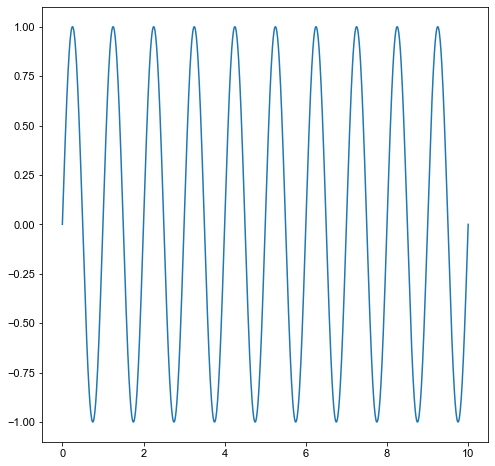

In [23]:

x = np.linspace(0,10,1000)

test = np.sin(2*np.pi*x)

plt.plot(x, test)

(array([ 10, 990], dtype=int64),)
1.0


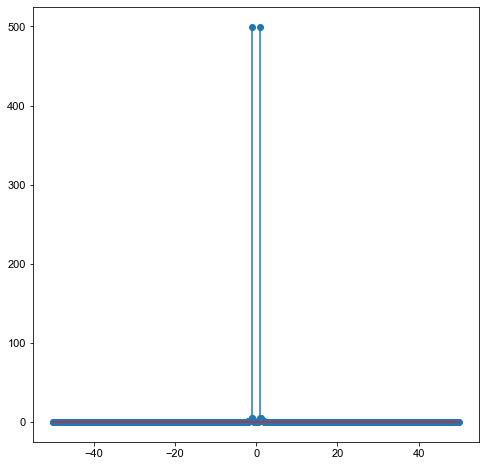

In [30]:
N = len(test)
n = np.arange(N)
# T = N/sr
# freq = n/T


ft_test = np.fft.fft(test)

fft_fre = np.fft.fftfreq(len(test),d=10/1000)
plt.stem(fft_fre, np.abs(ft_test))
print(np.where(np.abs(ft_test)**2 > 100.0))
print(1/fft_fre[10])

# Now adding in the real I_d values

5
16.0


c:\Users\nr421\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


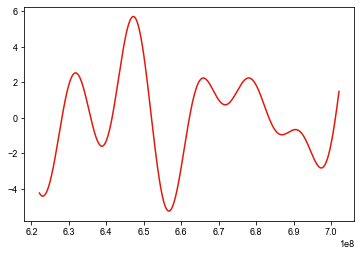

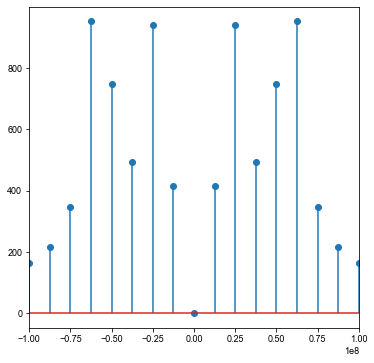

In [16]:
cm = 1/2.54
fig_fft = plt.figure(figsize=(15*cm, 10*cm))
fig_fft_stem = plt.figure(figsize=(15*cm, 15*cm))
ax_fft = fig_fft.add_subplot(111)
ax_fft_freq = fig_fft_stem.add_subplot(111) 
xvals_test = np.linspace(wvln_start_list[-3], wvln_start_list[-3]+0.08,1000)
ax_fft.plot(1e9*xvals_test, 2*Id_data_list_list[-3]-np.mean(2*Id_data_list_list[-3]), color = color_theme[0])
# ax_fft.plot(1e9*wvln_list_slant, np.sin(2*np.pi/16 *np.linspace(710, 780,1000)))
fft_id = np.fft.fft(2*Id_data_list_list[-3]-np.mean(2*Id_data_list_list[-3]))
fft_id_freq = np.fft.fftfreq(len(xvals_test), 80e-9/1000)

ax_fft_freq.stem(fft_id_freq, np.abs(fft_id))
ax_fft_freq.set_xlim(-100000000,100000000)
print(np.argmax(np.abs(fft_id)))
print(1/fft_id_freq[np.argmax(np.abs(fft_id))]*1e9)

plt.show()

In [17]:
def find_major_freq(id_list, wvln_spacing):
    fft_id = np.fft.fft(2*id_list - 2*np.mean(id_list))
    fft_id_freq = np.fft.fftfreq(len(id_list), wvln_spacing)
    max_component = np.argmax(np.abs(fft_id))#

    # print(fft_id_freq[max_component])
    max_list = np.argsort(np.abs(fft_id))[-4:]
    # print(max_list)
    # print(fft_id[max_component], fft_id[max_list])
    characteristic_lengths = np.mean(np.abs(1/fft_id_freq[max_list]*1e9))

    return characteristic_lengths

[21.333333333333336, 18.0, 28.0, 18.0, 30.0, 18.0, 18.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 23.333333333333336, 30.0]


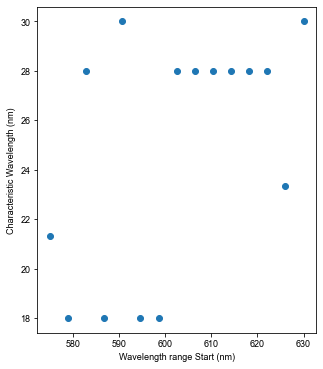

In [18]:
lengths_list = []
for data_list in Id_data_list_list:
    avg_length = find_major_freq(data_list, 80e-9/1000)
    # avg_length = [x if x<3e+10 else np.NaN for x in avg_length]
    # print(avg_length)
    lengths_list.append(avg_length)

# wvln_starts = np.linspace(0.45,0.75,number_of_wavelength_ranges)
print(lengths_list)
fig_length_as_lambd = plt.figure(figsize=(5,6))
ax_length_as_lambd = fig_length_as_lambd.add_subplot(111)
# for i in range(3):
ax_length_as_lambd.scatter(wvln_start_list*1000, lengths_list)
ax_length_as_lambd.set_xlabel('Wavelength range Start (nm)')
ax_length_as_lambd.set_ylabel('Characteristic Wavelength (nm)')
plt.show()

# Characteristic wavelength coupling changes

In [19]:

wvln_list = np.linspace(0.71,0.79, 1000)*1e-6 ## must be in microns
# beta_list = vec_beta_pred(wvln_list, 4.35, 1.63)
Id_multiplier_list = []
input_core = np.zeros(12, dtype=complex)
input_core[5] = 1.0
number_of_multiplier_steps = 15
multiplier_list = np.linspace(0.01,4,number_of_multiplier_steps)
for n in multiplier_list:
    Id_data = Id_for_different_wavelengths_coupling(0.25, wvln_list, input_core, n)#vals_with_beta, vecs, input_core)
    Id_multiplier_list.append(Id_data)
    # Iprint(2*np.mean(Id_data))

[21.333333333333336, 18.0, 28.0, 18.0, 30.0, 18.0, 18.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 23.333333333333336, 30.0]


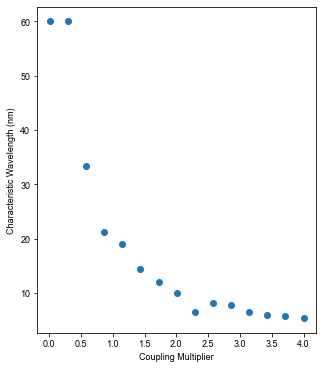

In [20]:
lengths_list_coupling = []
for data_list in Id_multiplier_list:
    avg_length = find_major_freq(data_list, 80e-9/1000)
    # avg_length = [x if x<3e+10 else np.NaN for x in avg_length]
    # print(avg_length)
    lengths_list_coupling.append(avg_length)

# wvln_starts = np.linspace(0.45,0.75,number_of_wavelength_ranges)
print(lengths_list)
fig_length_as_lambd = plt.figure(figsize=(5,6))
ax_length_as_lambd = fig_length_as_lambd.add_subplot(111)
# for i in range(3):
ax_length_as_lambd.scatter(multiplier_list, lengths_list_coupling)
ax_length_as_lambd.set_xlabel('Coupling Multiplier')
ax_length_as_lambd.set_ylabel('Characteristic Wavelength (nm)')
plt.show()

# Using SciPy find peaks

In [35]:
from scipy.signal import find_peaks

16.216216216216225


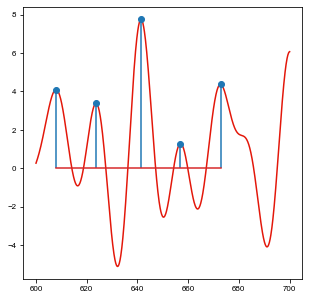

In [36]:
peak_list,_ = find_peaks(2*Id_data_uniform)
wvln_list = np.diff(1e9*wvln_list_slant[peak_list])
print(np.mean(wvln_list))

fig_find_peaks = plt.figure(figsize=(5,5))
ax_find_peaks = fig_find_peaks.add_subplot(111)
ax_find_peaks.plot(1e9*wvln_list_slant, 2*Id_data_uniform, color = color_theme[0])
ax_find_peaks.stem(1e9*wvln_list_slant[peak_list], 2*Id_data_uniform[peak_list])
plt.show()

7.499999999999999e-07
[21.333333333333336, 18.0, 28.0, 18.0, 30.0, 18.0, 18.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 23.333333333333336, 30.0]


c:\Users\nr421\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nr421\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


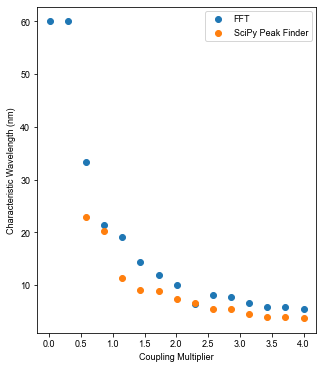

In [25]:

print(np.mean(wvln_list))

lengths_list_coupling_scipy = []
for data_list in Id_multiplier_list:
    peak_list,_ = find_peaks(2*data_list)
    wvln_list = np.diff(1e9*wvln_list_slant[peak_list])
    lengths_list_coupling_scipy.append(np.mean(wvln_list))

# wvln_starts = np.linspace(0.45,0.75,number_of_wavelength_ranges)
print(lengths_list)
fig_length_as_lambd = plt.figure(figsize=(5,6))
ax_length_as_lambd = fig_length_as_lambd.add_subplot(111)
# for i in range(3):
ax_length_as_lambd.scatter(multiplier_list, lengths_list_coupling, label='FFT')
ax_length_as_lambd.scatter(multiplier_list, lengths_list_coupling_scipy, label='SciPy Peak Finder')
ax_length_as_lambd.set_xlabel('Coupling Multiplier')
ax_length_as_lambd.set_ylabel('Characteristic Wavelength (nm)')
plt.legend()
plt.show()

c:\Users\nr421\Anaconda3\lib\site-packages\numpy\ma\core.py:3337: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


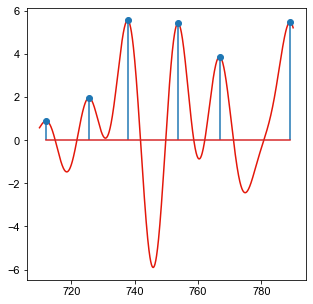

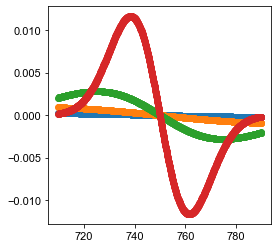

In [33]:
fig_der = plt.figure(figsize=(4,4))
ax_der = fig_der.add_subplot(111)

for n,i in enumerate(np.geomspace(std*5,std/2,4)):
    y_norm_slant = std_weighting_func_norm(wvln_list_slant,i)
    
    ax_der.scatter(wvln_list_slant[:-1]*1e9, np.diff(y_norm_slant))

plt.show()

In [26]:
def intensities_bar_at_z(z,evals,evecs,input_vec):
    # find supermodes
    supe = super_mode(z,evals,evecs,input_vec)
    # a_vals = core_basis(supe,12)
    # Intensity in each core
    # norm_vals = a_vals*np.conj(a_vals)
    
    norm_vals = supe*np.conj(supe)
#     print(norm_vals)
    norm_vals = norm_vals/np.sum(norm_vals)
    # print(norm_vals)
    # split cores into a & b
    a_norm = norm_vals[::2]
    b_norm = norm_vals[1::2]
    # find unweighted difference
    diff_list = a_norm - b_norm
    # weight the difference
    scaled_diff_list = diff_list*np.arange(1,7)
    # Calculate final values for use
    I_d = np.sum(scaled_diff_list)
    unweighted_diff = np.sum(diff_list)
    
    
    return norm_vals

prop_consts = vec_beta_pred(0.75, 4.35, 1.63)
        
prop_consts_i = np.ones(12)*prop_consts

strong_coupling = p(0.75)
weak_coupling = p(0.75)*0.45
eigenvalues, eigenvectors = SSH_eigvecs(weak_coupling, strong_coupling, prop_consts_i)
intensities = intensities_bar_at_z(0.05, eigenvalues, eigenvectors, input_core)

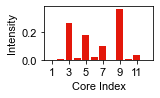

In [49]:
fig_bar = plt.figure(figsize=(5*cm,2.5*cm))
ax_bar = fig_bar.add_subplot(111)

ax_bar.bar(np.arange(1,13), intensities, color=color_theme[0])
ax_bar.set_xticks(np.arange(1,13,2))
ax_bar.set_xlabel('Core Index')
ax_bar.set_ylabel('Intensity')
fig_bar.savefig('intensity bar plot.svg', dpi=300)
plt.show()

In [12]:
print(vec_beta_pred(700e-9, 4.35, 1.63)*0.0089)

116257.8041277145


In [27]:
# To add twist to analytics we model the twisted propagation constant as so: 

def prop_changes_from_twist(beta_0, alpha, hel_rad):
    delta_beta_change = beta_0*(np.sqrt(1+(alpha*hel_rad)**2) - 1)

    return delta_beta_change

vec_prop_from_twist = np.vectorize(prop_changes_from_twist)

In [28]:
def SSH_eigvecs_twist(w, v, betas, twist_rate):
    # onsite = np.diag(betas)
    hel_rad_list = [0, 2*4.35e-6, 15.07e-6, 4*4.35e-6, 15.08e-6,4*4.35e-6, 15.07e-6,4*4.35e-6,15.07e-6,4*4.35e-6, 15.08e-6,4*4.35e-6]
    twist_list = vec_prop_from_twist(betas, twist_rate, hel_rad_list)
    # print(twist_list)
    diag_twist = np.diag(twist_list)
    h = np.array([[0,w,0,0,0,0,0,0,0,0,0,0],
                [w,0,v,0,0,0,0,0,0,0,0,0],
                [0,v,0,w,0,0,0,0,0,0,0,0],
                [0,0,w,0,v,0,0,0,0,0,0,0],
                [0,0,0,v,0,w,0,0,0,0,0,0],
                [0,0,0,0,w,0,v,0,0,0,0,0],
                [0,0,0,0,0,v,0,w,0,0,0,0],
                [0,0,0,0,0,0,w,0,v,0,0,0],
                [0,0,0,0,0,0,0,v,0,w,0,0],
                [0,0,0,0,0,0,0,0,w,0,v,0],
                [0,0,0,0,0,0,0,0,0,v,0,w],
                [0,0,0,0,0,0,0,0,0,0,w,0]])    
    eigvals,eigvecs = np.linalg.eigh(h+diag_twist)#+onsite)
    return eigvals,eigvecs

def Id_for_different_wavelengths_twist(z, each_wvln, input_vec, twist_rate_alpha, rand_mag=0.0, trivial=False):#eigenvalue_list_at_each_wvln, eigenvectors, input_vec):

    Id_wvln_list = np.zeros(len(each_wvln), dtype=complex)
    unweighted_id_wvln_list = np.zeros(len(each_wvln), dtype=complex)
    prop_consts_at_each_wvln = vec_beta_pred(each_wvln, 4.35, 1.63)
    rand_list = (np.random.rand(12)-0.5)

    for i, beta_at_wvln in enumerate(prop_consts_at_each_wvln):
        
        prop_consts_i = np.ones(12)*beta_at_wvln
        if trivial is True:
            weak_coupling = p(each_wvln[i])
            strong_coupling = p(each_wvln[i])*0.45
        else:
            strong_coupling = p(each_wvln[i])
            weak_coupling = p(each_wvln[i])*0.45
        eigenvalues, eigenvectors = SSH_eigvecs_twist(weak_coupling, strong_coupling, beta_at_wvln, twist_rate_alpha)
        # print(eigenvectors[:,0])
        Id_wvln_list[i], unweighted_id_wvln_list[i] = I_d_bar_at_z(z, eigenvalues, eigenvectors, input_vec)

    return Id_wvln_list,unweighted_id_wvln_list




In [31]:
wvln_list_large = np.linspace(0.65,0.75, 1000)*1e-6 ## must be in microns


twisting = np.linspace(0, 100, 100)
Id_data_list_twisted = np.zeros(len(twisting))
input_core = np.zeros(12, dtype=complex)
input_core[6] = 1.0
for n,alph in enumerate(twisting):
    Id_data_twisted, unid_data_twisted = Id_for_different_wavelengths_twist(0.32, wvln_list_large, input_core, alph)
    Id_data_list_twisted[n] = 2*np.mean(Id_data_twisted)
    

<ipython-input-31-c0ff16f725a7>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  Id_data_list_twisted[n] = 2*np.mean(Id_data_twisted)


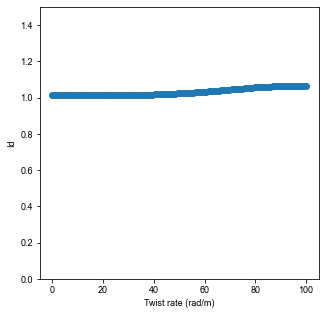

In [32]:
fig_twisting = plt.figure(figsize=(5,5))
ax_twist = fig_twisting.add_subplot(111)
ax_twist.scatter(twisting, Id_data_list_twisted)
ax_twist.set_ylabel('Id')
ax_twist.set_xlabel('Twist rate (rad/m)')
ax_twist.set_ylim(0,1.5)
plt.show()